# 1. Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import json

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint

!pip install visualkeras
import visualkeras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,confusion_matrix,f1_score,accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.8 MB/s eta 0:00:00


# 2. Importing and Exploring the dataset

Here the dataset used is **GTSRB(German Traffic Sign Recognition Benchmark)**. It is a widely used dataset for the development and evaluation of traffic sign recognition algorithms. The dataset consists of images of traffic signs captured under various conditions, such as different lighting conditions, weather conditions, and viewpoints.

The GTSRB dataset contains more than 50,000 images of traffic signs from 43 different classes. Each class represents a specific type of traffic sign, including speed limit signs, stop signs, yield signs, and various other regulatory, warning, and informational signs.

Here we extract each images and resize it to a size of 32x32 pixels and create the modified dataset 'data'

In [2]:
data = []
labels = []
classes = 43
cur_path = '../input/gtsrb-german-traffic-sign/Train'

for i in tqdm(os.listdir(cur_path)):
    dir = cur_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir+'/'+j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_NEAREST)
        data.append(img)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

100%|██████████| 43/43 [03:47<00:00,  5.30s/it]

(39209, 32, 32, 3) (39209,)


* Randomly displaying five images from the training dataset,

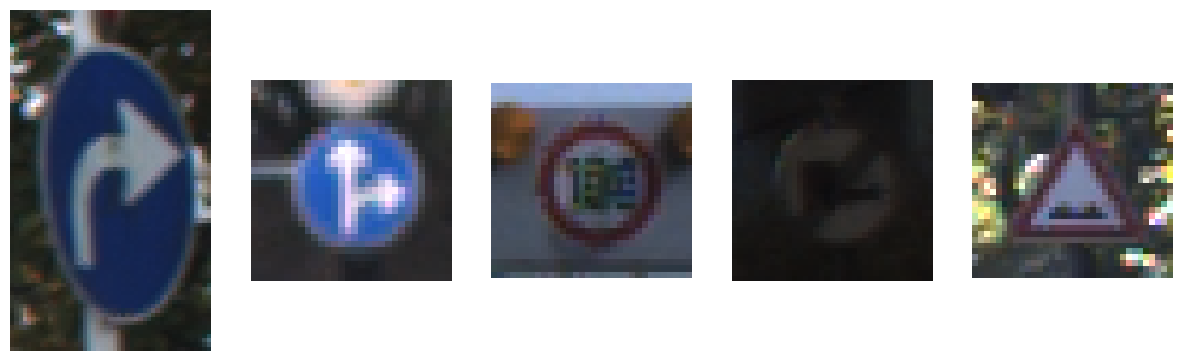

In [3]:
path = '../input/gtsrb-german-traffic-sign/Train'
image_folders = random.sample(os.listdir(path),5)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
k =0
for i in image_folders:
    image_file = random.sample(os.listdir(os.path.join(path,i)),1)
    temp_path = os.path.join(path,i)
    final_path = os.path.join(temp_path,image_file[0])
    img = Image.open(final_path)
    ax[k].imshow(img)
    ax[k].axis('off')
    k = k+1
    
plt.show()

* Next the labels for the 43 classes were made into a dictionary so that instead of the number, the corresponding label can be shown during prediction

In [4]:
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

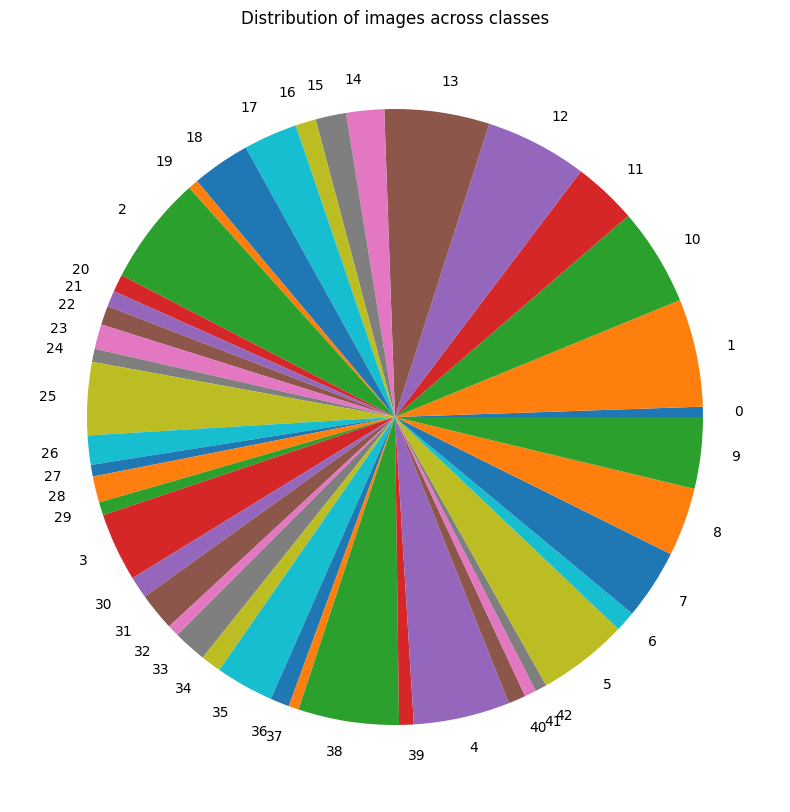

In [5]:
classes = sorted(os.listdir(cur_path))
num_images = [len(os.listdir(os.path.join(cur_path, cls))) for cls in classes]
data_num = {'Classes': classes, 'Number of images': num_images}
df = pd.DataFrame(data_num)
plt.figure(figsize=(10, 10))
plt.pie(df['Number of images'], labels=df['Classes'])
plt.title('Distribution of images across classes')
plt.show()

# Building the Model

The architecture consists of several layers working together to learn and classify images.

The initial layers are convolutional layers responsible for capturing local features in the input images. **The first convolutional layer** has 32 filters with a kernel size of 5x5 and applies the rectified linear unit (ReLU) activation function, introducing non-linearity. **The second convolutional layer** also has 32 filters with the same kernel size and activation function. These convolutional layers help extract meaningful features from the images.

After each convolutional layer, **a max-pooling layer** with a pool size of 2x2 is applied to downsample the spatial dimensions. This reduces the computational complexity and provides translational invariance. To prevent overfitting, **a dropout layer** with a rate of 0.25 is inserted after the max-pooling layer.

The architecture continues with **two more sets of convolutional layers, each followed by a max-pooling layer and a dropout layer**. The third convolutional layer has 64 filters with a kernel size of 3x3 and ReLU activation, while the fourth convolutional layer also has 64 filters with the same kernel size and activation function. These additional layers enable the network to capture more complex features and patterns in the images.

Next, **a flattening layer** is introduced to convert the 2D feature maps from the previous layer into a 1D feature vector. This prepares the data for the subsequent fully connected layers.

**The dense layers come after the flattening layer.** The first dense layer has 256 neurons and applies the ReLU activation function, allowing the network to learn high-level representations of the extracted features. To prevent overfitting, **a dropout layer** with a rate of 0.5 is added after this dense layer.

**The final dense layer** consists of 43 neurons, which is equal to the number of output classes in the classification task. It uses the softmax activation function to produce class probabilities, indicating the likelihood of each input image belonging to a particular class.

In [6]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (32,32,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(43, activation= 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

* A Layered view of the model is given below

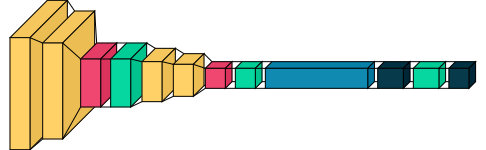

In [7]:
visualkeras.layered_view(model)

# Training the Model

Now the dataset is split into training and test datasets. The model is then trained using the training datsets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.25, random_state=21)

print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

((29406, 32, 32, 3), (29406,)) ((9803, 32, 32, 3), (9803,))


We set up two callbacks: EarlyStopping and ModelCheckpoint. EarlyStopping monitors the validation loss and stops training if it doesn't improve for 20 epochs. ModelCheckpoint saves the best model based on validation loss. The model is then trained using fit() with the specified parameters, including the callbacks.

In [9]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50


2023-05-20 15:49:27.483235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


230/230 [==============================] - 10s 10ms/step - loss: 3.1612 - accuracy: 0.2756 - val_loss: 1.5664 - val_accuracy: 0.5764
Epoch 2/50
230/230 [==============================] - 2s 9ms/step - loss: 1.5068 - accuracy: 0.5515 - val_loss: 0.8614 - val_accuracy: 0.7422
Epoch 3/50
230/230 [==============================] - 2s 8ms/step - loss: 1.0224 - accuracy: 0.6849 - val_loss: 0.5529 - val_accuracy: 0.8520
Epoch 4/50
230/230 [==============================] - 2s 8ms/step - loss: 0.8000 - accuracy: 0.7509 - val_loss: 0.3858 - val_accuracy: 0.8886
Epoch 5/50
230/230 [==============================] - 2s 8ms/step - loss: 0.6679 - accuracy: 0.7891 - val_loss: 0.2930 - val_accuracy: 0.9145
Epoch 6/50
230/230 [==============================] - 2s 8ms/step - loss: 0.5864 - accuracy: 0.8170 - val_loss: 0.2738 - val_accuracy: 0.9260
Epoch 7/50
230/230 [==============================] - 2s 8ms/step - loss: 0.5265 - accuracy: 0.8352 - val_loss: 0.2156 - val_accuracy: 0.9407
Epoch 8/50
230/

We then save the training history of a model to a JSON file named 'history.json'for future use instead of running the model each time.

In [10]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

Then the training and test accuracy and training and test loss graphs are plotted 

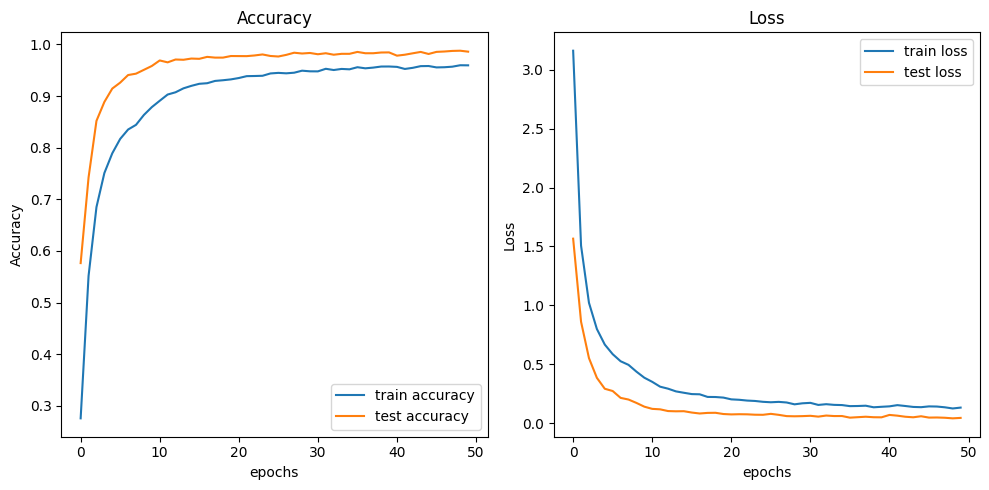

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.lineplot(data=history.history, x=range(len(history.history['accuracy'])),
             y='accuracy', ax=ax1, label='train accuracy', palette=['blue'])
sns.lineplot(data=history.history, x=range(len(history.history['val_accuracy'])),
             y='val_accuracy', ax=ax1, label='test accuracy', palette=['orange'])
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=history.history, x=range(len(history.history['loss'])),
             y='loss', ax=ax2, label='train loss', palette=['blue'])
sns.lineplot(data=history.history, x=range(len(history.history['val_loss'])),
             y='val_loss', ax=ax2, label='test loss', palette=['orange'])
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Testing the Model

The test dataset is imported and a modified dataset is created as before, after resizing the images to 32x32 size. 5 random images from the datset is also shown, just exploring :)

In [12]:
y_test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')

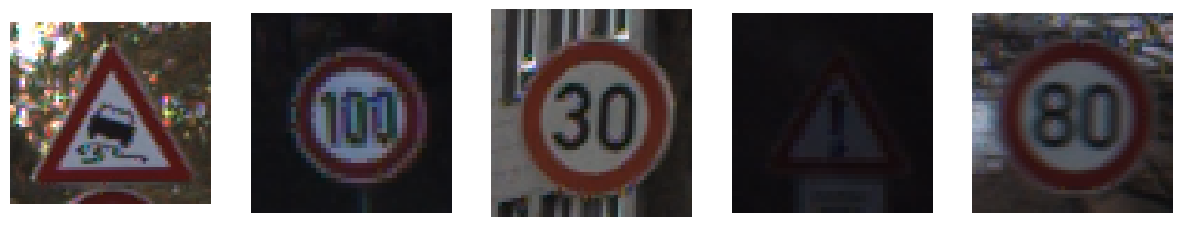

In [13]:
path = '../input/gtsrb-german-traffic-sign/Test'
image_files = random.sample(os.listdir(path),5)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

for i in range(len(image_files)):
    final_path = os.path.join(path,image_files[i])
    img = Image.open(final_path)
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

In [14]:
labels_test = y_test['ClassId'].values
img_test = y_test['Path'].values
test_dir = '../input/gtsrb-german-traffic-sign'
data = []
for img in img_test:
    img_path = os.path.join(test_dir, img)
    image = cv2.imread(img_path, -1)
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_NEAREST)
    data.append(np.array(image))
    
X_test = np.array(data)

We then predict the labels for the test datset. The test accuracy comes out to be around 96 percent

In [15]:
pred = np.argmax(model.predict(X_test),axis =1)
print("Test accuracy: ", accuracy_score(labels_test, pred) * 100 )

395/395 [==============================] - 1s 3ms/step
Test accuracy:  95.5027711797308


We can see the implementation here, as 5 random images from the dataset are being predicted by the model. We can see that the predictions are accurate

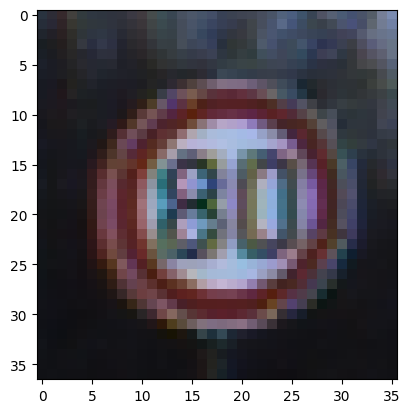

1/1 [==============================] - 0s 116ms/step
Predicted class: 80_speed


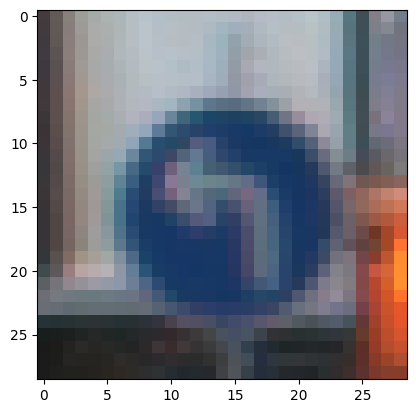

1/1 [==============================] - 0s 19ms/step
Predicted class: stop


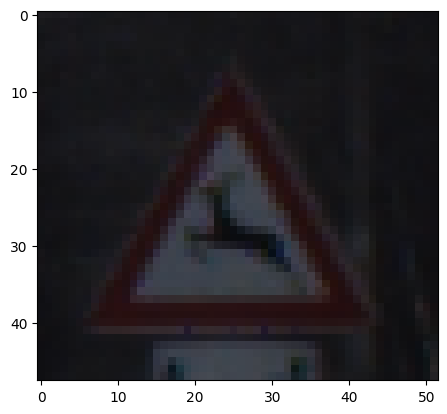

1/1 [==============================] - 0s 19ms/step
Predicted class: attention_deer


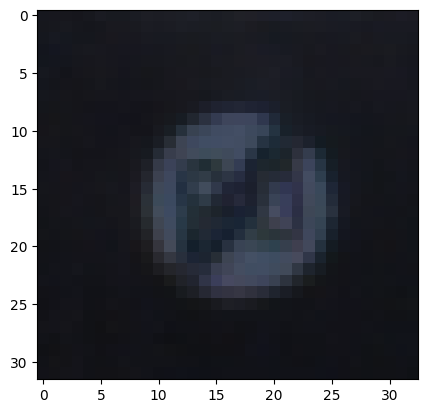

1/1 [==============================] - 0s 19ms/step
Predicted class: 80_lifted


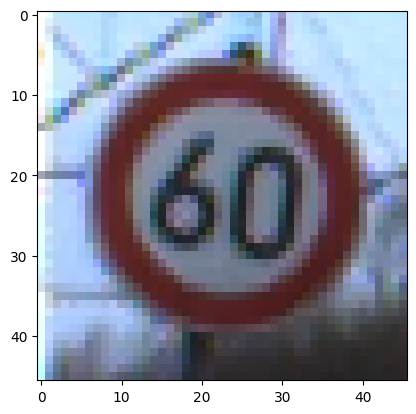

1/1 [==============================] - 0s 20ms/step
Predicted class: 60_speed


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

t = y_test.sample(n = 5)
img_test = t['Path'].values
test_dir = '../input/gtsrb-german-traffic-sign'

for i in range(5):
    img_path = os.path.join(test_dir, img_test[i])
    img1 = Image.open(img_path)
    plt.imshow(np.array(img1))
    plt.show()

    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    print("Predicted class:", label_map[str(predicted_class)])

# Performance Analysis

We do the performance analysis of the model using various methods like the Confusion Matrix, Accuracy, Precision, Recall and F1 Score

<AxesSubplot: >

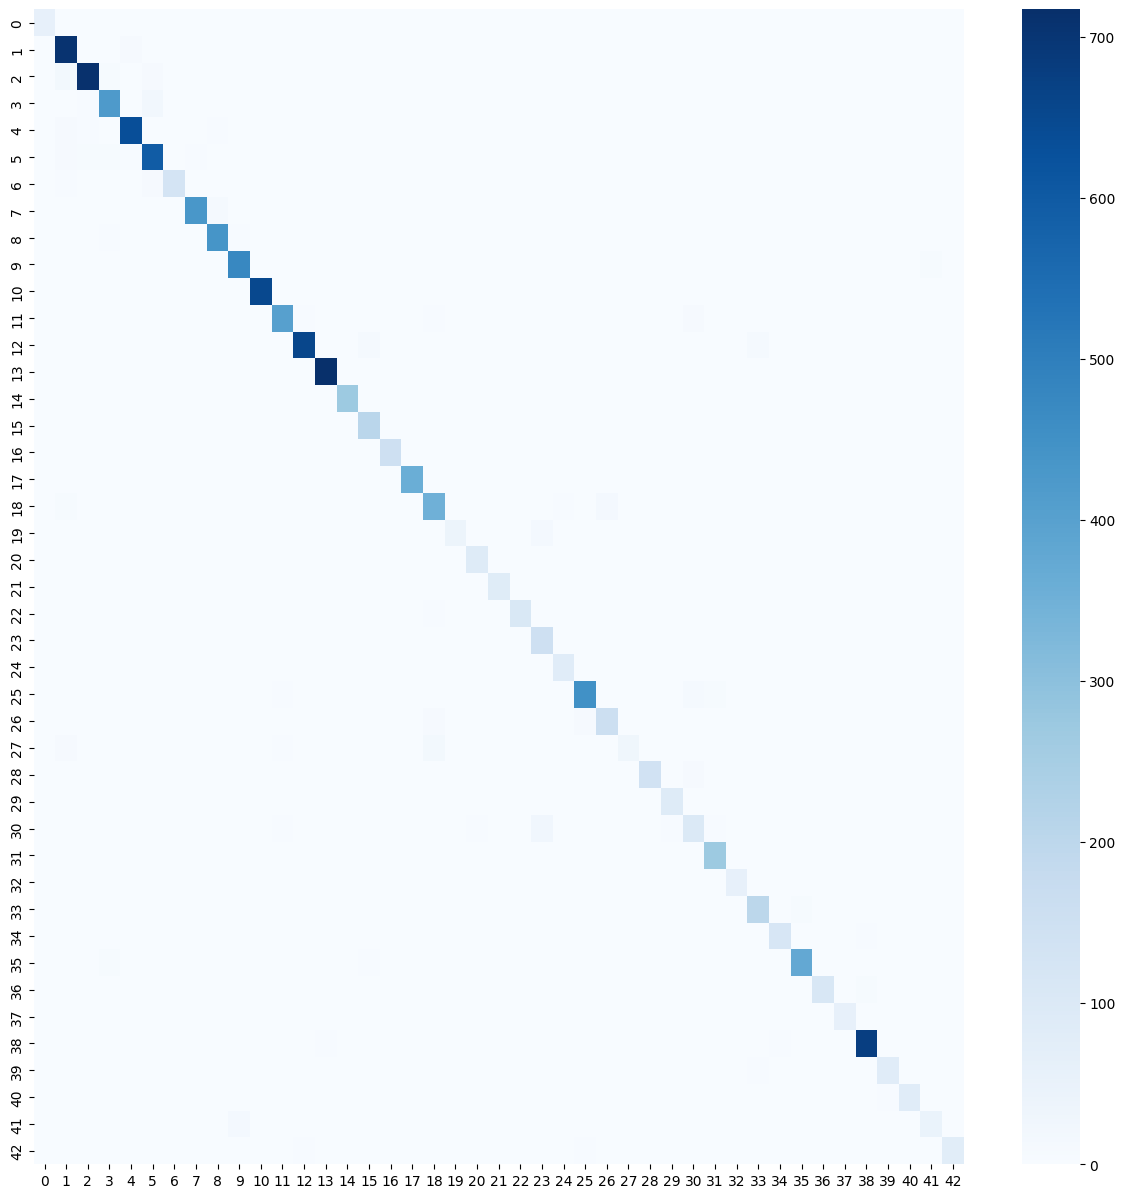

In [17]:
fig = plt.figure(figsize=(15, 15))
y_true = np.array(y_test['ClassId'])
cm = confusion_matrix(y_true,pred)
sns.heatmap(cm, cmap="Blues")

In [18]:
y_pred= pred
precision = precision_score(y_true,y_pred,average = 'macro')
recall = recall_score(y_true,y_pred,average = 'macro')
f1 = f1_score(y_true,y_pred, average = 'macro')
accuracy = accuracy_score(y_true,y_pred)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

Precision: 0.9474430573297327
Recall: 0.9302515996062509
F1 Score: 0.9359601346837121
Accuracy: 0.9550277117973079
